## Observations and Insights

As per the 'Statistical Distribution of Final Tumor Volume by Drug' it would appear that Ramicane followed by Capomulin are the most effective followed by Ceftamin and lastly Infubinol. This is suggested by both the IQR and median results of both drugs.

Across the entirety of the dataset there appears to be a strong positive correlation between the weight of the mouse and the overall final tumor mass. Following this, the effectiveness of the drug is strongly correlated to the mouse weight.

Both the entirety and quality of the data appears to be consistent and reliable. This is indicated by the lack of potential outliers indicated by the 'Statistical Distribution of Final Tumor Volume by Drug'. Additionally, out of 249 mice tested, only 1 (g989) appeared to have corrupted data.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
# https://docs.scipy.org/doc/scipy/reference/stats.html

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
data = pd.merge(mouse_metadata, study_results, how='outer', on='Mouse ID')
# Display the data table for preview
data

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [2]:
#check dtypes for any potential irregularities.
data.dtypes

Mouse ID               object
Drug Regimen           object
Sex                    object
Age_months              int64
Weight (g)              int64
Timepoint               int64
Tumor Volume (mm3)    float64
Metastatic Sites        int64
dtype: object

In [3]:
# Checking the number of mice.
mouse_id_list = len(data['Mouse ID'].unique())
print(f'There are a total of {mouse_id_list} unique mouse IDs in the data.')

There are a total of 249 unique mouse IDs in the data.


In [4]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
duplicated_mouse_id = data.loc[data.duplicated(subset=['Mouse ID', 'Timepoint',]),'Mouse ID'].unique()
print(f'The duplicated mice ID by both Mouse ID and Timepoint is {duplicated_mouse_id}.')

The duplicated mice ID by both Mouse ID and Timepoint is ['g989'].


In [5]:
# Optional: Get all the data for the duplicate mouse ID. 
duplicated_mouse_id_data = data[data.duplicated(subset=['Mouse ID', 'Timepoint'])]
duplicated_mouse_id_data

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
909,g989,Propriva,Female,21,26,0,45.000000,0
911,g989,Propriva,Female,21,26,5,47.570392,0
913,g989,Propriva,Female,21,26,10,49.880528,0
915,g989,Propriva,Female,21,26,15,53.442020,0
917,g989,Propriva,Female,21,26,20,54.657650,1


In [6]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
clean_data = data[data['Mouse ID'].isin(duplicated_mouse_id) == False]
clean_data.rename(columns = {'Age_months':"Age (months)"}, inplace = True)
clean_data

C:\Users\vellam1\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Mouse ID,Drug Regimen,Sex,Age (months),Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [7]:
# Checking the number of mice in the clean DataFrame.
cleaned_mouse_id_list = len(clean_data['Mouse ID'].unique())
print(f'There are a total of {cleaned_mouse_id_list} unique mouse IDs in the data when duplicates are removed.\
\ni.e. there appears to be {mouse_id_list - cleaned_mouse_id_list} ID with duplicated data.')


There are a total of 248 unique mouse IDs in the data when duplicates are removed.
i.e. there appears to be 1 ID with duplicated data.


## Summary Statistics

In [8]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# This method is the most straighforward, creating multiple series and putting them all together at the end.




In [9]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# This method produces everything in a single groupby function

#Create Calcs
regimen_summary = clean_data.groupby('Drug Regimen')
drug_mean = regimen_summary['Tumor Volume (mm3)'].mean()
drug_median = regimen_summary['Tumor Volume (mm3)'].median()
drug_var = regimen_summary['Tumor Volume (mm3)'].var()
drug_std = regimen_summary['Tumor Volume (mm3)'].std()
drug_sem = regimen_summary['Tumor Volume (mm3)'].sem()

#create DF
regimen_summary_stats = pd.DataFrame({'Mean':drug_mean,
                                     'Median':drug_median,
                                     'Variance':drug_var,
                                     'S.Dev.':drug_std,
                                     'SEM':drug_sem})

#formatting
pd.options.display.float_format = '{:.2f}'.format
regimen_summary_stats


,Mean,Median,Variance,S.Dev.,SEM
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,0.33
Ceftamin,52.59,51.78,39.29,6.27,0.47
Infubinol,52.88,51.82,43.13,6.57,0.49
Ketapril,55.24,53.70,68.55,8.28,0.60
Naftisol,54.33,52.51,66.17,8.13,0.60
Placebo,54.03,52.29,61.17,7.82,0.58
Propriva,52.32,50.45,43.85,6.62,0.54
Ramicane,40.22,40.67,23.49,4.85,0.32
Stelasyn,54.23,52.43,59.45,7.71,0.57


## Bar and Pie Charts

In [10]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pandas. 
def bar_chart_pandas():
    bar_plot = clean_data['Drug Regimen'].value_counts().plot.bar(width=0.7, zorder=3, figsize=(10,6))
    bar_plot.set_xlabel('Drug Regimen')
    bar_plot.set_ylabel('Number of Mice')
    bar_plot.set_title('Number of Mice for Each Treatment Regimen', fontweight = 'bold')
    bar_plot.grid(zorder=0)

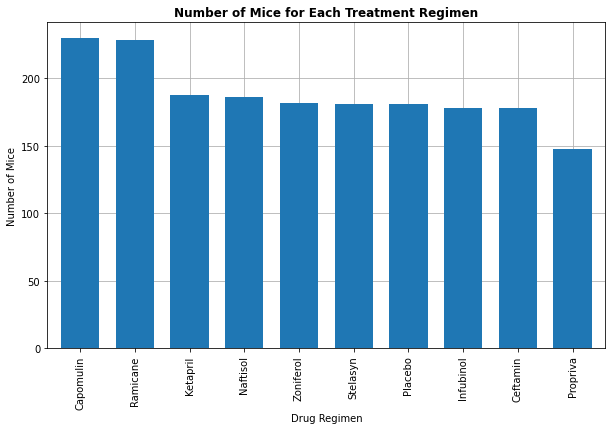

In [11]:
bar_chart_pandas()

In [12]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pyplot.
def bar_chart_pyplot():
    y_axis = clean_data['Drug Regimen'].value_counts()
    x_axis = np.arange(len(y_axis))
    x_ticks = [x for x in x_axis]
    plt.figure(figsize=(10,6))
    plt.xlabel("Drug Regimen")
    plt.ylabel("Number of Mice")
    plt.xticks(x_ticks, y_axis.index.values, rotation = 90)
    plt.title('Number of Mice for Each Treatment Regimen', fontweight = 'bold')
    plt.grid(zorder = 0)
    plt.bar(x_axis, y_axis, width = 0.7, zorder = 3)
    plt.show()

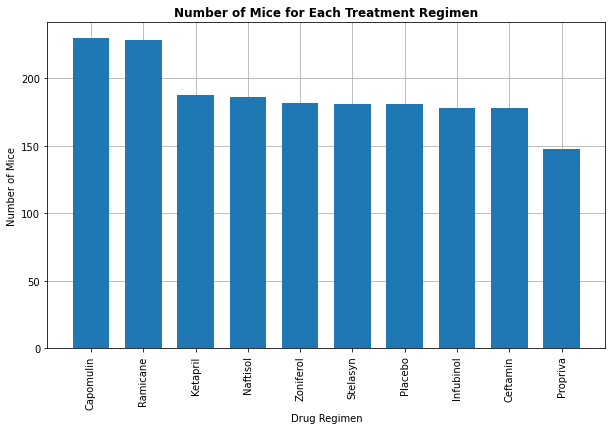

In [13]:
bar_chart_pyplot()

In [14]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
def pie_chart_pandas():
    data = clean_data['Sex'].value_counts()
    pie_plot = data.plot.pie(autopct = '%1.1f%%', startangle = 90, figsize=(10,6))
    pie_plot.set_title('Gender Distribution of Mice', fontweight = 'bold')
    pie_plot.set_ylabel('') #hide y_label for matting

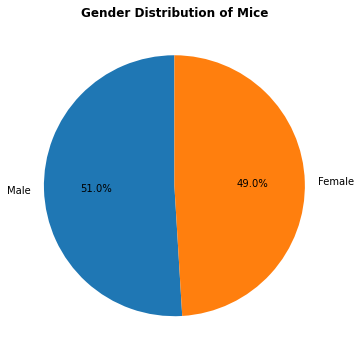

In [15]:
pie_chart_pandas()

In [16]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
def pie_chart_pyplot():
    data = clean_data['Sex'].value_counts()
    plt.figure(figsize=(10,6))
    plt.pie(data, labels = data.index.values, autopct = '%1.1f%%', startangle = 90)
    plt.title('Gender Distribution of Mice', fontweight = 'bold')


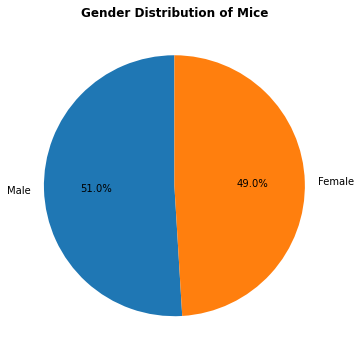

In [17]:
pie_chart_pyplot()

## Quartiles, Outliers and Boxplots

In [18]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse

#as analysis is based on mouse id, group by mouse id and find max value corresponding to any particular mouse id, rename column to max_timepoint for merge later.

max_timepoint = pd.DataFrame(clean_data.groupby('Mouse ID')['Timepoint'].max()).reset_index().rename(columns = {'Timepoint':'max_timepoint'})

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
merge1 = pd.merge(clean_data, max_timepoint, on = 'Mouse ID')
merge1.head()

,Mouse ID,Drug Regimen,Sex,Age (months),Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,max_timepoint
0,k403,Ramicane,Male,21,16,0,45.00,0,45
1,k403,Ramicane,Male,21,16,5,38.83,0,45
2,k403,Ramicane,Male,21,16,10,35.01,1,45
3,k403,Ramicane,Male,21,16,15,34.22,1,45
4,k403,Ramicane,Male,21,16,20,33.00,1,45


In [19]:
# Put treatments into a list for for loop (and later for plot labels)
drugs = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

# Create empty list to fill with tumor vol data (for plotting)
drug_results = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
    # Locate the rows which contain mice on each drug and get the tumor volumes
    # add subset 
    # Determine outliers using upper and lower bounds
    
for drug in drugs:
    #subset dfs that narrow down both Drug and Max Timepoint
    qob_df = merge1.loc[merge1['Drug Regimen'] == drug]
    tumor_volumes_df = qob_df.loc[qob_df['Timepoint'] == qob_df['max_timepoint']]
    
    #find tumor volume and append to results list
    tumour_volume = tumor_volumes_df['Tumor Volume (mm3)']
    drug_results.append(tumour_volume)
    
    #iqr calcs
    quartiles = tumour_volume.quantile([0.25,0.5,0.75])
    lower_quartile = quartiles[0.25]
    upper_quartile = quartiles[0.75]
    inter_quartile = upper_quartile - lower_quartile
    
    #lower and upper bounds
    lower_bound = lower_quartile - (1.5 * inter_quartile)
    upper_bound = upper_quartile + (1.5 * inter_quartile)
    
    #outliers = above / below upper / lower bounds respectively
    outliers = (tumour_volume.loc[(tumor_volumes_df['Tumor Volume (mm3)'] >= upper_bound) |
                                 (tumor_volumes_df['Tumor Volume (mm3)'] <= lower_bound)]).count()
    
    
    #print statistical results per drug to illustrate any outliers (inc. formatting for cleanliness)
    print(f'The IQR for {drug}: {inter_quartile : ,.2f}\
    \nLower Bounds of {drug}: {lower_bound : ,.2f}\
    \nUpper Bounds of {drug}: {upper_bound : ,.2f}\
    \n# of outliers for {drug}: {outliers : ,.0f}\
    \n')
    
    
# drug_results provides 4 lists corresponding to the four specified drugs.
# drug_check = qob_df['Drug Regimen'].unique()
# drug_check

The IQR for Capomulin:  7.78    
Lower Bounds of Capomulin:  20.70    
Upper Bounds of Capomulin:  51.83    
# of outliers for Capomulin:  0    

The IQR for Ramicane:  9.10    
Lower Bounds of Ramicane:  17.91    
Upper Bounds of Ramicane:  54.31    
# of outliers for Ramicane:  0    

The IQR for Infubinol:  11.48    
Lower Bounds of Infubinol:  36.83    
Upper Bounds of Infubinol:  82.74    
# of outliers for Infubinol:  1    

The IQR for Ceftamin:  15.58    
Lower Bounds of Ceftamin:  25.36    
Upper Bounds of Ceftamin:  87.67    
# of outliers for Ceftamin:  0    



In [20]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
#ref document - https://matplotlib.org/3.1.1/gallery/pyplots/boxplot_demo_pyplot.html#sphx-glr-gallery-pyplots-boxplot-demo-pyplot-py

def box_plot():
    flierprops = dict(marker = 'o', markerfacecolor = 'r', markersize = 10, markeredgecolor = 'black')
    plt.figure(figsize=(10,6))
    plt.boxplot(drug_results, flierprops = flierprops)
    plt.ylabel('Final Tumor Volume (mm3)')
    plt.xlabel('Drug')
    plt.xticks([1,2,3,4], labels=drugs)
    plt.title('Statistical Distribution of Final Tumor Volume by Drug', fontweight = 'bold')


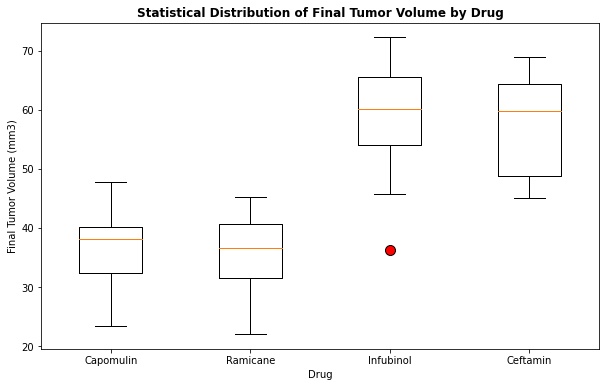

In [21]:
box_plot()

## Line and Scatter Plots

In [22]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
#find a list of mice which have been treated with Capomulin
merge1.loc[merge1['Drug Regimen'] == 'Capomulin', 'Mouse ID'].unique()

array(['s185', 'x401', 'm601', 'f966', 'u364', 'y793', 'r554', 'm957',
       't565', 'i738', 'w914', 'g288', 'l897', 'b742', 'b128', 'j246',
       'j119', 'w150', 'v923', 'g316', 's710', 'l509', 'r944', 'i557',
       'r157'], dtype=object)

In [23]:
#first result is mouse ID s185
#find data points pertaining to s185 with .loc
def s185_line_time_volume():
    mouse_s185 = clean_data.loc[clean_data['Mouse ID'] == 's185']
    plt.figure(figsize=(10,6))
    plt.plot(mouse_s185['Timepoint'], mouse_s185['Tumor Volume (mm3)'], marker = 'x', linewidth = 1.5, markersize=10, mew = 2)
    plt.xlabel('Timepoint')
    plt.xlim(mouse_s185['Timepoint'].min()-1,mouse_s185['Timepoint'].max()+5)
    plt.ylim(mouse_s185['Tumor Volume (mm3)'].min()-5,mouse_s185['Tumor Volume (mm3)'].max()+5)
    plt.ylabel('Tumor Volume (mm3)')
    plt.title('Mouse ID s185 Tumor Volume (mm3) by Timepoint', fontweight = 'bold')
    


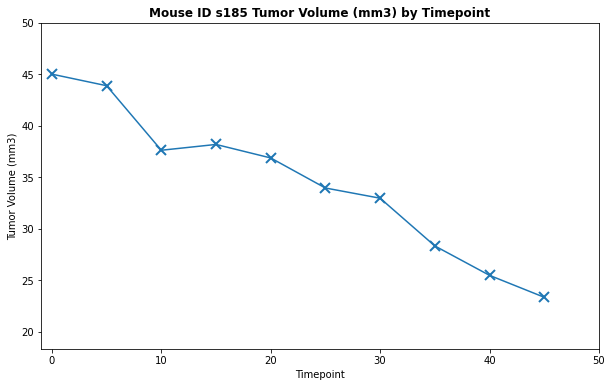

In [24]:
s185_line_time_volume()

In [25]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen

#find data points for Capomulin regimen
capomulin = clean_data.loc[clean_data['Drug Regimen'] == 'Capomulin']
#average tumor volume for each mouse in the capomulin regimen
avg_vol_capomulin = pd.DataFrame(capomulin.groupby('Mouse ID')['Tumor Volume (mm3)'].mean().reset_index().rename(columns={'Tumor Volume (mm3)':'avg_vol'}))
#merge the capomulin regimen df with the avg_vol df
avg_vol_capomulin = pd.merge(capomulin, avg_vol_capomulin, on = 'Mouse ID')
#create 2 column df as needed for scatter plot and then drop duplicate values
scatter_avg_vol_capomulin = avg_vol_capomulin[['Weight (g)', 'avg_vol']].drop_duplicates()

def scatter_weight_volume():
    plt.figure(figsize=(10,6))
    x_axis = scatter_avg_vol_capomulin['Weight (g)']
    y_axis = scatter_avg_vol_capomulin['avg_vol']
    plt.scatter(x_axis, y_axis)
    plt.xlabel('Weight (g)')
    plt.ylabel('Average Tumor Volume (mm3)')
    plt.title('Mouse Weight (g) compared to Average Tumor Volume (mm3)', fontweight = 'bold')


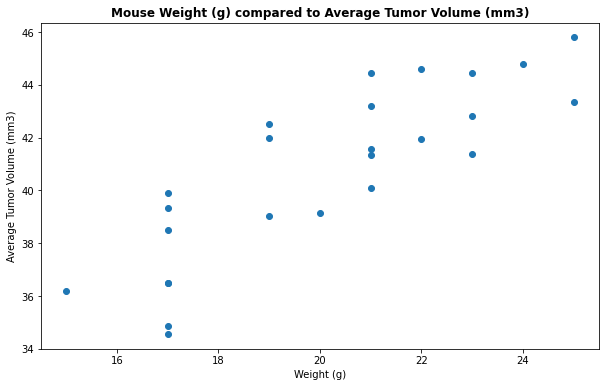

In [26]:
scatter_weight_volume()

## Correlation and Regression

In [27]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
# recreate scatter plot
def scatter_regression_weight_volume():
    plt.figure(figsize=(10,6))
    x_axis = scatter_avg_vol_capomulin['Weight (g)']
    y_axis = scatter_avg_vol_capomulin['avg_vol']
    correlation = st.pearsonr(x_axis, y_axis)
    print(f'The correlation coefficient between weight and tumor volume is: {round(correlation[0],2)}')
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
    regress_values = x_axis * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_axis, y_axis)
    plt.plot(x_axis,regress_values,"r-")
    plt.annotate( line_eq, xy = (0.1,0.18), xycoords = 'figure fraction', horizontalalignment = 'left', verticalalignment='bottom', fontsize=15, color="red")
    plt.xlabel('Weight (g)')
    plt.ylabel('Average Tumor Volume (mm3)')
    plt.title('Mouse Weight (g) compared to Average Tumor Volume (mm3)', fontweight = 'bold')

The correlation coefficient between weight and tumor volume is: 0.84


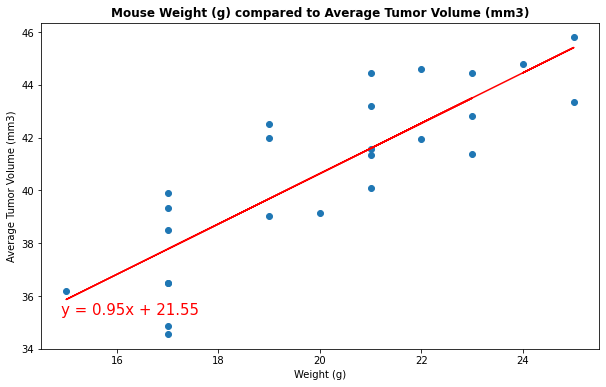

In [28]:
scatter_regression_weight_volume()